In [1]:
import yfinance as yf
import pandas as pd

In [2]:
start_date = "2021-07-01"
end_date = "2021-08-31"
idx = "^DJI"


Index = yf.download(idx, # ticker
interval="1d", # daily frequency
start=start_date, end=end_date) # sampling period
Index.tail() # preview the last five observations

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-24,35382.718750,35445.468750,35356.179688,35366.261719,35366.261719,228710000
2021-08-25,35388.769531,35501.140625,35287.628906,35405.500000,35405.500000,237230000
2021-08-26,35449.679688,35498.449219,35205.101562,35213.121094,35213.121094,239740000
2021-08-27,35231.109375,35479.179688,35231.109375,35455.800781,35455.800781,240990000
2021-08-30,35471.800781,35510.710938,35374.460938,35399.839844,35399.839844,245390000


In [3]:
Index = pd.DataFrame(Index['Adj Close'].rename(idx))
Index.head()

,^DJI
Date,
2021-06-30,34502.511719
2021-07-01,34633.531250
2021-07-02,34786.351562
2021-07-06,34577.371094
2021-07-07,34681.789062


## Take the data from web:

In [4]:
page = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
page[1] # the second html table contains the information we need

page[1].head(5) # page[1] is a dataframe

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,3.62%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.00%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,4.18%
3,Apple Inc.,NASDAQ,AAPL,Information technology,2015-03-19,NaN,2.78%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,4.12%


In [5]:
page[0].head(5) # 用 html parse 的第一個 dataframe 就是 wikipedia 上的目錄

,0,1
0,Historical logarithmic graph of the DJIA from ...,Historical logarithmic graph of the DJIA from ...
1,Foundation,"February 16, 1885; 136 years ago[1]May 26, 189..."
2,Operator,S&P Dow Jones Indices
3,Exchanges,New York Stock ExchangeNASDAQ
4,Trading symbol,^DJI$INDU.DJIDJIA


In [6]:
constituents = page[1]['Symbol'] # we only need tickers
constituents.head()

0     MMM
1     AXP
2    AMGN
3    AAPL
4      BA
Name: Symbol, dtype: object

### test for Ticker object:

In [7]:
stk = yf.Ticker('JNJ') 
stk.info['floatShares'] # 取得流通在外股數

2629665336

In [8]:
for i in constituents:
    print(i) # print out the ticker so we know the downloading progress
    prc = yf.download(i, interval="1d", start=start_date, end=end_date) # prc stands fro price
    prc = pd.DataFrame(prc['Adj Close']) # select adjusted close price only

    prc.columns = [i] # rename the column with the ticker of the stock (i.e., 'MMM', 'JNJ',....)

    try:
        df_prc = pd.concat([df_prc, prc], axis=1) # if the dataframe already exists, join the newly downloaded data to the existing table
    except:
        df_prc = prc # create the dataframe for the first ticker

    stk = yf.Ticker(i)

    # 取得 floatshares (真的在市場上，有流動性的股數)
    try:
        stk.info['floatShares']
    except:
        stk.info['floatShares'] = None

    try:
        stk.info['sharesOutstanding']
    except:
        stk.info['sharesOutstanding'] = None

    # first option
    if stk.info['floatShares']:
        mcap = prc * stk.info['floatShares']

    # second option: 如果找不到 float shares
    elif stk.info['sharesOutstanding']:
        mcap = prc * stk.info['sharesOutstanding']
    
    # last option: 如果都找不到 float share 貨 shares outstanding，那就藉由計算: 市值/昨日收盤價 取得 shares outstanding 的 proxy
    else:
        mcap = prc * (stk.info['marketCap']/stk.info['previousClose'])

    # 把最新取得的總市值加入 data fame 中
    try:
        df_mcap = pd.concat([df_mcap, mcap], axis=1)
    except:
        df_mcap = mcap

MMM
[*********************100%***********************]  1 of 1 completed
AXP
[*********************100%***********************]  1 of 1 completed
AMGN
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
BA
[*********************100%***********************]  1 of 1 completed
CAT
[*********************100%***********************]  1 of 1 completed
CVX
[*********************100%***********************]  1 of 1 completed
CSCO
[*********************100%***********************]  1 of 1 completed
KO
[*********************100%***********************]  1 of 1 completed
DOW
[*********************100%***********************]  1 of 1 completed
GS
[*********************100%***********************]  1 of 1 completed
HD
[*********************100%***********************]  1 of 1 completed
HON
[*********************100%***********************]  1 of 1 completed
IBM
[*********************100%**********************

## calcualate price-weighted DJIA

In [9]:
df_mcap.head() # market shares for each stock

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-30,1.139364e+11,1.054957e+11,1.370897e+11,2.258234e+12,1.283215e+11,1.182471e+11,1.973511e+11,2.203241e+11,2.087911e+11,4.668876e+10,...,1.944933e+11,3.251208e+11,2.310430e+11,3.701451e+10,3.789790e+11,2.178487e+11,3.936110e+11,3.735240e+10,2.047624e+11,3.190546e+11
2021-07-01,1.142003e+11,1.068656e+11,1.388613e+11,2.263345e+12,1.284126e+11,1.177473e+11,2.001208e+11,2.221532e+11,2.082123e+11,4.685108e+10,...,1.989121e+11,3.258678e+11,2.317146e+11,3.753867e+10,3.831905e+11,2.188596e+11,3.958498e+11,3.458345e+10,2.022940e+11,3.217592e+11
2021-07-02,1.146592e+11,1.078642e+11,1.398736e+11,2.307699e+12,1.267788e+11,1.183178e+11,1.998570e+11,2.241206e+11,2.090612e+11,4.685846e+10,...,2.011027e+11,3.274581e+11,2.347602e+11,3.739032e+10,3.874209e+11,2.194428e+11,4.017081e+11,3.420006e+10,2.034410e+11,3.214869e+11
2021-07-06,1.129384e+11,1.085428e+11,1.370334e+11,2.341664e+12,1.264896e+11,1.160140e+11,1.959379e+11,2.217764e+11,2.079036e+11,4.569272e+10,...,2.015685e+11,3.276508e+11,2.366992e+11,3.729390e+10,3.882727e+11,2.193262e+11,4.033410e+11,3.386637e+10,2.031942e+11,3.152790e+11
2021-07-07,1.146420e+11,1.094518e+11,1.367916e+11,2.383709e+12,1.241541e+11,1.166497e+11,1.939407e+11,2.229485e+11,2.096014e+11,4.592882e+10,...,2.016314e+11,3.301086e+11,2.349872e+11,3.762767e+10,3.895977e+11,2.197927e+11,4.040143e+11,3.371727e+10,2.028602e+11,3.136998e+11


In [10]:
df_prc.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-30,197.125229,164.391312,241.882187,136.755112,239.559998,216.468338,103.346657,52.279869,53.704681,62.602482,...,154.235489,134.086670,244.270004,148.880066,399.039337,54.757252,233.501694,52.096992,140.502975,175.770004
2021-07-01,197.581741,166.526031,245.008041,137.064651,239.729996,215.553238,104.797104,52.713886,53.555805,62.820126,...,157.739700,134.394745,244.979996,150.988312,403.473785,55.011349,234.829865,48.235020,138.809204,177.259995
2021-07-02,198.375687,168.082153,246.794250,139.750626,236.679993,216.597626,104.658966,53.180737,53.774158,62.830017,...,159.476837,135.050613,248.199997,150.391632,407.928131,55.157940,238.305145,47.700287,139.596298,177.110001
2021-07-06,195.398407,169.139526,241.782944,141.807541,236.139999,212.380264,102.606636,52.624496,53.476406,61.266937,...,159.846222,135.130112,250.250000,150.003799,408.825012,55.128624,239.273819,47.234871,139.426926,173.690002
2021-07-07,198.345917,170.556000,241.356247,144.353729,231.779999,213.544022,101.560738,52.902615,53.913109,61.583511,...,159.896149,136.143753,248.440002,151.346313,410.220093,55.245895,239.673279,47.026920,139.197769,172.820007


WHY SUM??  
Remember 道瓊工業指數的定義:
>
每個組成公司的一股股票價格總和後的平均值

In [11]:
PWI = df_prc.sum(axis=1) # sum up prices at the same time period
PWI = pd.DataFrame(PWI.rename('PWI')) # put the result in a dataframe
PWI.tail()

,PWI
Date,
2021-08-24,5359.864159
2021-08-25,5365.775154
2021-08-26,5336.622791
2021-08-27,5373.658321
2021-08-30,5365.910099


## Compare with actual index

In [12]:
egg = Index.copy()
egg.iloc[0]

^DJI    34502.511719
Name: 2021-06-30 00:00:00, dtype: float64

In [13]:
egg.columns

Index(['^DJI'], dtype='object')

In [14]:
type(egg.iloc[0])

pandas.core.series.Series

In [15]:
print(egg.head())

egg2 = egg.divide(egg.iloc[0] / 100) # 除上多少就是將基準 (基期)設在多少
print(egg2.head())

                    ^DJI
Date                    
2021-06-30  34502.511719
2021-07-01  34633.531250
2021-07-02  34786.351562
2021-07-06  34577.371094
2021-07-07  34681.789062
                  ^DJI
Date                  
2021-06-30  100.000000
2021-07-01  100.379739
2021-07-02  100.822664
2021-07-06  100.216968
2021-07-07  100.519607


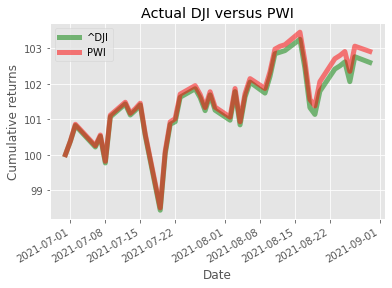

In [35]:
import matplotlib.pyplot as plt
TS = Index.join(PWI) # join the actual index with the replicated index
# TS[idx] = TS[idx]/TS[idx][0] # compute cumulative returns of $1 investment in the actual index (跟 pct_change() 的效果一樣??)
# TS.PW_rep = TS.PWI/TS.PWI[0] # compute cumulative returns of $1 investment in the replicated index

TS = TS.divide(TS.iloc[0] / 100) # element wise division
# 作用: 將第一筆資料 (最早日期的資料) 的數值設為 100

plt.style.use('ggplot')
fig = TS.plot(color=["green","red"],alpha=0.5,linewidth=5)
plt.title('Actual DJI versus PWI')
plt.legend(loc='best')
plt.ylabel('Cumulative returns')
plt.show()

Q: ggplot 怎麼知道要畫哪兩個?   
ANS: 看起來是因為 ```TS``` 只有兩個 columns，所以也就只能畫這兩個資訊

In [17]:
TS.columns

Index(['^DJI', 'PWI'], dtype='object')

## 將 Daily Return 比較圖畫出 -> 適合用 bar graph

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [19]:
RTS = TS.pct_change()
RTS.head()

,^DJI,PWI
Date,,
2021-06-30,NaN,NaN
2021-07-01,0.003797,0.003882
2021-07-02,0.004412,0.004670
2021-07-06,-0.006008,-0.005992
2021-07-07,0.003020,0.003014


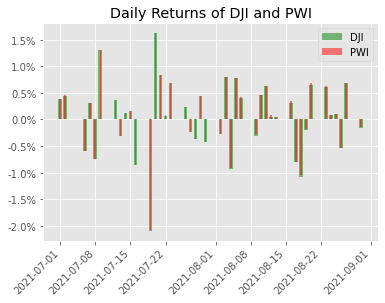

In [20]:
fig, ax = plt.subplots()
ax.bar(RTS.index, RTS['^DJI'], color='green', alpha=0.5, width=0.75)
ax.bar(RTS.index,RTS['PWI'],color='red',alpha=0.5,width=0.35)

# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
ax.yaxis.set_major_formatter(FuncFormatter('{0:.1%}'.format))
plt.setp(ax.get_xticklabels(), ha='right', rotation=45)

plt.title('Daily Returns of DJI and PWI')
plt.legend(['DJI', 'PWI'])
plt.show()

Code 解析:
- ```FuncFormatter(lambda y, _: '{:.1%}'.format(y))``` 可以用 ```FuncFormatter('{0:.1%}'.format)``` 代替，其中:  
    - '{0:.1%}'.format creates a formatting function.
    - 冒號前面的 0 tells the formatter to replace theurly-brackets and its contents with the first argument passed to the function (就是指 x 的內容) 
    - 冒號後面的 :.1%, tells the formatter how to render the value. The .1 specifies 1 decimal places and % specifies rendering as a percent.
- ```plt.setp```: setp 的 p 我猜是指 properity，其實就是把很多資料要如何呈現用一個方法呈現，其中:
    - 第一個參數: ```ax.get_xticklabels()```: 代表我們後面要套用的 properity 是用在 x 軸上的數據
    - ```ha```: horizontal Alignment (水平對齊): 可以選 ```left```, ```center```，或 ```right``` (分別表示靠左、靠中、靠右)
    - ```rotation```: 將 x 軸數據旋轉 45 %

## 創建 value-weighted index:

In [21]:
df_mcap.head() # 這些數字就是市值 (i.e. 股價*流通在外股數)

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-30,1.139364e+11,1.054957e+11,1.370897e+11,2.258234e+12,1.283215e+11,1.182471e+11,1.973511e+11,2.203241e+11,2.087911e+11,4.668876e+10,...,1.944933e+11,3.251208e+11,2.310430e+11,3.701451e+10,3.789790e+11,2.178487e+11,3.936110e+11,3.735240e+10,2.047624e+11,3.190546e+11
2021-07-01,1.142003e+11,1.068656e+11,1.388613e+11,2.263345e+12,1.284126e+11,1.177473e+11,2.001208e+11,2.221532e+11,2.082123e+11,4.685108e+10,...,1.989121e+11,3.258678e+11,2.317146e+11,3.753867e+10,3.831905e+11,2.188596e+11,3.958498e+11,3.458345e+10,2.022940e+11,3.217592e+11
2021-07-02,1.146592e+11,1.078642e+11,1.398736e+11,2.307699e+12,1.267788e+11,1.183178e+11,1.998570e+11,2.241206e+11,2.090612e+11,4.685846e+10,...,2.011027e+11,3.274581e+11,2.347602e+11,3.739032e+10,3.874209e+11,2.194428e+11,4.017081e+11,3.420006e+10,2.034410e+11,3.214869e+11
2021-07-06,1.129384e+11,1.085428e+11,1.370334e+11,2.341664e+12,1.264896e+11,1.160140e+11,1.959379e+11,2.217764e+11,2.079036e+11,4.569272e+10,...,2.015685e+11,3.276508e+11,2.366992e+11,3.729390e+10,3.882727e+11,2.193262e+11,4.033410e+11,3.386637e+10,2.031942e+11,3.152790e+11
2021-07-07,1.146420e+11,1.094518e+11,1.367916e+11,2.383709e+12,1.241541e+11,1.166497e+11,1.939407e+11,2.229485e+11,2.096014e+11,4.592882e+10,...,2.016314e+11,3.301086e+11,2.349872e+11,3.762767e+10,3.895977e+11,2.197927e+11,4.040143e+11,3.371727e+10,2.028602e+11,3.136998e+11


In [22]:
VWI = df_mcap.sum(axis=1)
VWI.head()

Date
2021-06-30    1.010403e+13
2021-07-01    1.014385e+13
2021-07-02    1.026373e+13
2021-07-06    1.025808e+13
2021-07-07    1.033280e+13
dtype: float64

In [23]:
VWI = pd.DataFrame(VWI.rename('VWI')) # rename the column
VWI.tail()


,VWI
Date,
2021-08-24,1.070812e+13
2021-08-25,1.068644e+13
2021-08-26,1.062042e+13
2021-08-27,1.067537e+13
2021-08-30,1.077121e+13


## equal-weighted index:

equal weighted: 
> 指數中的每一家公司，不論大小，在指數中的比重都相同

In [24]:
EWI = df_prc.pct_change().mean(axis=1)
# .mean() 表示將 pct_change 每個 row 都做平均 (也就是將各 column, i.e. 各股票在當天的漲跌相加，並取平均)
# 因此，最後會只剩一個 Column

In [25]:
EWI.head()

Date
2021-06-30         NaN
2021-07-01    0.002187
2021-07-02    0.003872
2021-07-06   -0.006684
2021-07-07    0.003166
dtype: float64

In [26]:
EWI[0] = 0 # 因為只有一個 column，所以只需 specify 一個數值??
EWI.head()

Date
2021-06-30    0.000000
2021-07-01    0.002187
2021-07-02    0.003872
2021-07-06   -0.006684
2021-07-07    0.003166
dtype: float64

In [27]:
EWI = EWI + 1 # 將各天的百分比漲幅轉為"剩多少價值" (注意到我們前面已經把各股票的各天漲幅平均過了，所以現在討論的都是這個 equally weighted index，與個股無關)
EWI = EWI.cumprod() # 將前一個 row 的數值 (剩餘價值比例) * 今日剩餘價值比例


In [28]:
type(EWI)

pandas.core.series.Series

In [29]:
EWI = pd.DataFrame(EWI.rename("EWI"))
EWI.tail()

,EWI
Date,
2021-08-24,1.023343
2021-08-25,1.025043
2021-08-26,1.018529
2021-08-27,1.025725
2021-08-30,1.024868


In [30]:
egg4 = Index.join([PWI,VWI,EWI])
egg4.loc['2021-06-30', ['PWI', 'VWI', 'EWI']]

PWI    5.214087e+03
VWI    1.010403e+13
EWI    1.000000e+00
Name: 2021-06-30 00:00:00, dtype: float64

In [31]:
egg4.VWI.head()

Date
2021-06-30    1.010403e+13
2021-07-01    1.014385e+13
2021-07-02    1.026373e+13
2021-07-06    1.025808e+13
2021-07-07    1.033280e+13
Name: VWI, dtype: float64

In [32]:
egg4.EWI.head()

Date
2021-06-30    1.000000
2021-07-01    1.002187
2021-07-02    1.006068
2021-07-06    0.999344
2021-07-07    1.002508
Name: EWI, dtype: float64

In [33]:
egg4.divide(egg4.iloc[0] / 100).head()

,^DJI,PWI,VWI,EWI
Date,,,,
2021-06-30,100.000000,100.000000,100.000000,100.000000
2021-07-01,100.379739,100.388223,100.394187,100.218724
2021-07-02,100.822664,100.857055,101.580620,100.606816
2021-07-06,100.216968,100.252727,101.524636,99.934357
2021-07-07,100.519607,100.554889,102.264236,100.250761


### So, implement to matplotlib...

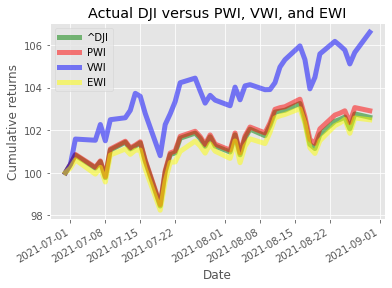

In [34]:
import matplotlib.pyplot as plt
TS = Index.join([PWI,VWI,EWI])
TS = TS.divide(TS.iloc[0] / 100)
plt.style.use('ggplot')
fig = TS.plot(color=["green","red","blue","yellow"],alpha=0.5,linewidth=5)
plt.title('Actual DJI versus PWI, VWI, and EWI')
plt.legend(loc='best')
plt.ylabel('Cumulative returns')
plt.show()
